A simple image classification trail using the sampled toy dataset from avainsolar images. It follows the tensorflow tutorial: https://www.tensorflow.org/tutorials/images/classification

This trail contains the data augmentation technique and dropout.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [27]:
import pathlib

data_dir = "/Users/xi/Documents/Argonne/aviansolar-DeepLearning/toy_dataset"
data_dir = pathlib.Path(data_dir)
print(data_dir)


/Users/xi/Documents/Argonne/aviansolar-DeepLearning/toy_dataset


In [28]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

110


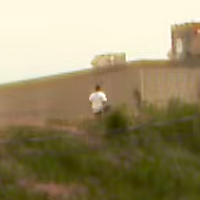

In [32]:
humans = list(data_dir.glob('human/*'))
PIL.Image.open(str(humans[0]))

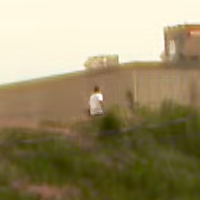

In [33]:
PIL.Image.open(str(humans[1]))

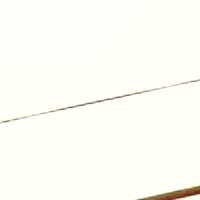

In [34]:
wires = list(data_dir.glob('wire/*'))
PIL.Image.open(str(wires[0]))

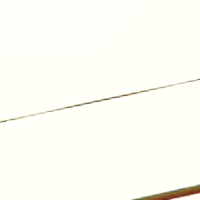

In [35]:
PIL.Image.open(str(wires[1]))

In [36]:
batch_size = 32
img_height = 180
img_width = 180

In [37]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 110 files belonging to 3 classes.
Using 88 files for training.


In [38]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 110 files belonging to 3 classes.
Using 22 files for validation.


In [39]:
class_names = train_ds.class_names
print(class_names)

['human', 'other', 'wire']


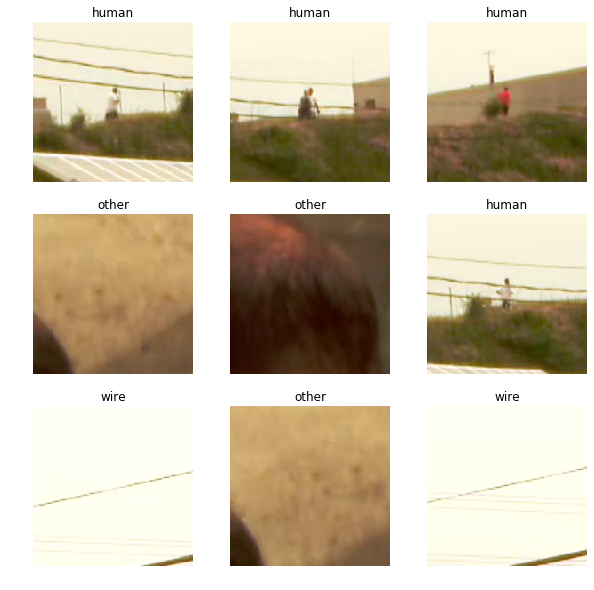

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [41]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [42]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [43]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [44]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [45]:
num_classes = 3

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [46]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [47]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 22, 22, 64)       

In [48]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
3/3 [==============================] - 4s 870ms/step - loss: 1.2422 - accuracy: 0.3677 - val_loss: 0.9783 - val_accuracy: 0.3636
Epoch 2/10
3/3 [==============================] - 2s 812ms/step - loss: 0.8622 - accuracy: 0.6583 - val_loss: 0.7584 - val_accuracy: 0.7727
Epoch 3/10
3/3 [==============================] - 2s 769ms/step - loss: 0.6339 - accuracy: 0.8079 - val_loss: 0.5983 - val_accuracy: 0.7727
Epoch 4/10
3/3 [==============================] - 2s 792ms/step - loss: 0.3990 - accuracy: 0.8465 - val_loss: 0.2174 - val_accuracy: 1.0000
Epoch 5/10
3/3 [==============================] - 2s 757ms/step - loss: 0.1708 - accuracy: 1.0000 - val_loss: 0.0458 - val_accuracy: 1.0000
Epoch 6/10
3/3 [==============================] - 2s 773ms/step - loss: 0.0363 - accuracy: 1.0000 - val_loss: 0.0074 - val_accuracy: 1.0000
Epoch 7/10
3/3 [==============================] - 2s 776ms/step - loss: 0.0056 - accuracy: 1.0000 - val_loss: 5.7217e-04 - val_accuracy: 1.0000
Epoch 8/10
3/3 [

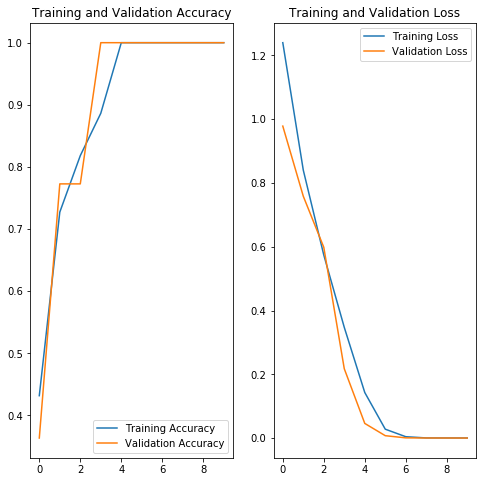

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [50]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

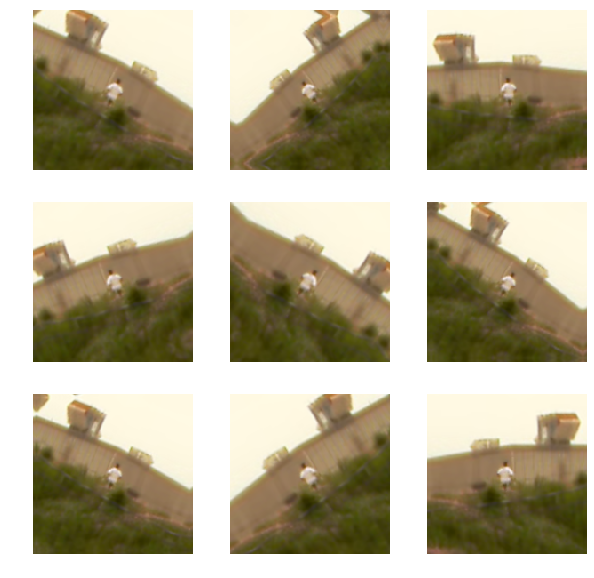

In [51]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [52]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [53]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [54]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_4 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 45, 45, 64)       

In [55]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
3/3 [==============================] - 5s 1s/step - loss: 1.4497 - accuracy: 0.5832 - val_loss: 0.9574 - val_accuracy: 0.3636
Epoch 2/15
3/3 [==============================] - 3s 886ms/step - loss: 0.9031 - accuracy: 0.7291 - val_loss: 0.8879 - val_accuracy: 0.9091
Epoch 3/15
3/3 [==============================] - 2s 757ms/step - loss: 0.8454 - accuracy: 0.8857 - val_loss: 0.7617 - val_accuracy: 0.3636
Epoch 4/15
3/3 [==============================] - 2s 784ms/step - loss: 0.6226 - accuracy: 0.6445 - val_loss: 0.6928 - val_accuracy: 0.4091
Epoch 5/15
3/3 [==============================] - 2s 689ms/step - loss: 0.4628 - accuracy: 0.6975 - val_loss: 0.3272 - val_accuracy: 1.0000
Epoch 6/15
3/3 [==============================] - 2s 698ms/step - loss: 0.2408 - accuracy: 1.0000 - val_loss: 0.1221 - val_accuracy: 1.0000
Epoch 7/15
3/3 [==============================] - 2s 799ms/step - loss: 0.1020 - accuracy: 1.0000 - val_loss: 0.0334 - val_accuracy: 1.0000
Epoch 8/15
3/3 [=======

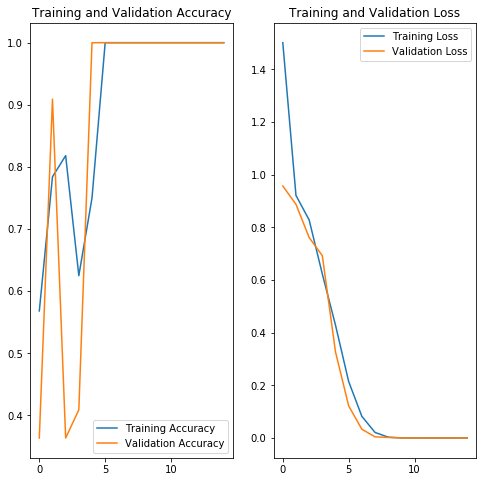

In [56]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()